In [1]:
#!pip install ipywidgets

In [2]:
import pandas as pd
import urllib.parse
import matplotlib.pyplot as plt
import numpy as np
import ffkkmo_ra
import ipywidgets as widgets

Получим датасет

In [3]:
df = pd.read_csv("ffkkmo_clean.csv", index_col='Unnamed: 0')

In [4]:
clubs = sorted(list(filter(lambda x : isinstance(x, str), df.club.unique())))
categoies = df.category.unique()
club = widgets.Dropdown(
    options=clubs,
    value=clubs[0],
    description='Школа:',
    disabled=False,
)
category = widgets.Dropdown(
    options=categoies,
    value=categoies[0],
    description='Разряд:',
    disabled=False,
)
limit_val = widgets.IntSlider(
    value=50,
    min=0,
    max=200,
    step=1,
    description='Количество:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
season = widgets.Dropdown(
    options=[2021, 2122, 2223, 2324, 2425],
    value=2425,
    description='Сезон:',
    disabled=False,
)

In [5]:
display(club)
display(category)
display(season)
display(limit_val)

Dropdown(description='Школа:', options=('Балашиха, АНО ДЮСШ «Олимп»', 'Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина…

Dropdown(description='Разряд:', options=('3-й юношеский разряд, мальчики', '3-й юношеский разряд, девочки', '2…

Dropdown(description='Сезон:', index=4, options=(2021, 2122, 2223, 2324, 2425), value=2425)

IntSlider(value=50, continuous_update=False, description='Количество:', max=200)

In [6]:
ffkkmo_ra.get_top_df(df, 5)

Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»                    2495
Щелково, МАУ ГОЩ «ФОК «Ледовая арена» им. В.А. Третьяка     1931
Одинцово, МБУ ДО СШ «Одинцово»                              1910
Лыткарино, МАУ «ЛСК Лыткарино»                              1831
Наро-Фоминский, МАУ ДО ЦСШ №1                               1634
Остальные                                                  19607
Name: club, dtype: int64

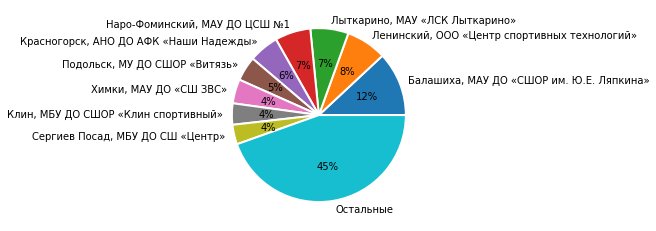

In [7]:
ffkkmo_ra.pie_of_winners(df, 2425, 3, 9, "Доля призеров в сезоне 24-25")
plt.title("", fontsize=16)
plt.xlabel("", fontsize=18)
plt.ylabel("", fontsize=18);

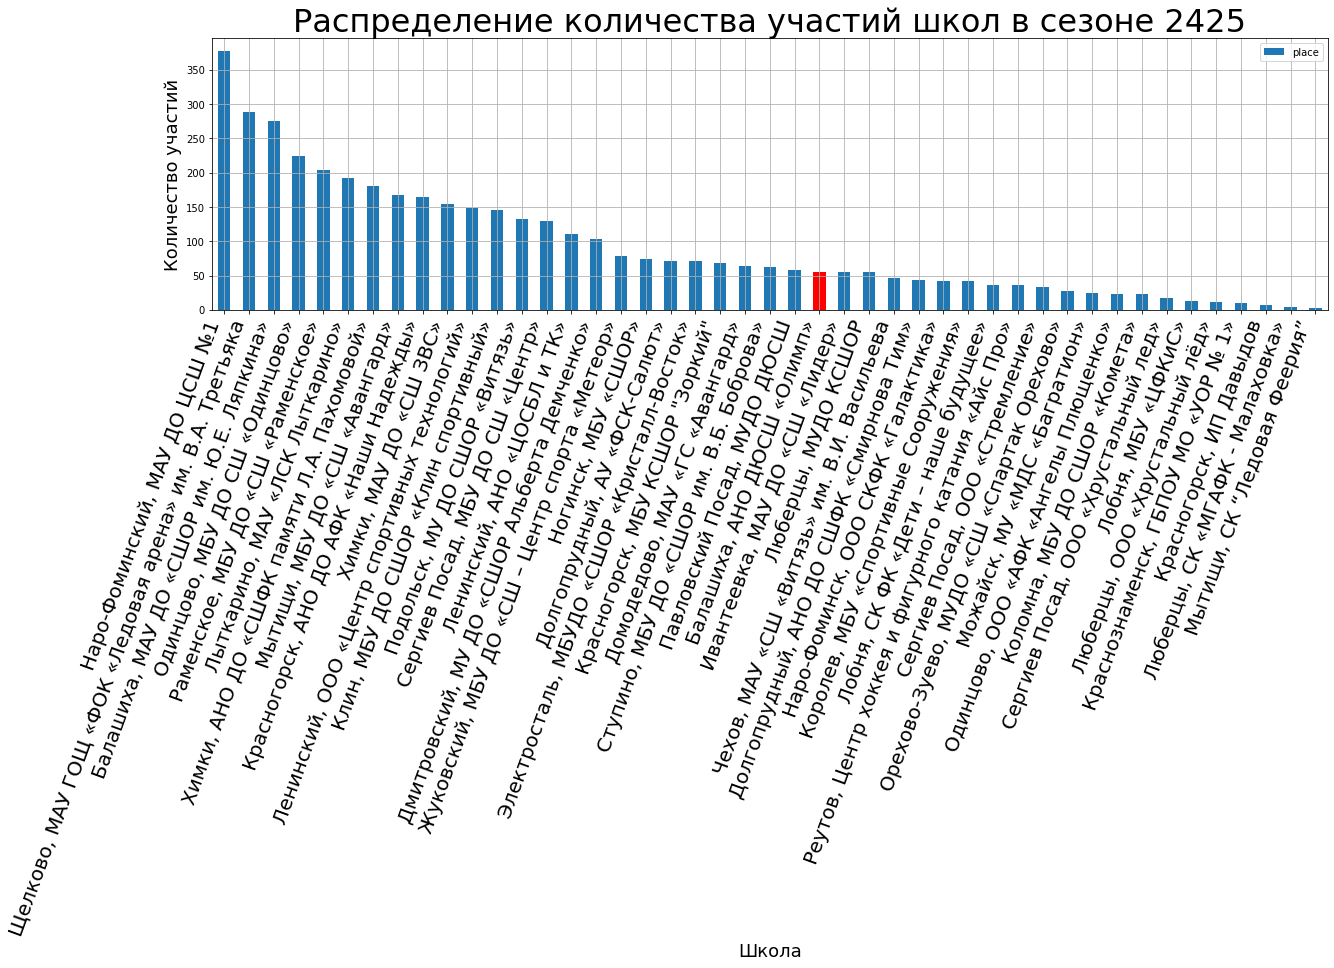

In [8]:
ffkkmo_ra.plot_clubs_in_season(df, season.value, limit_val.value, club.value)

In [9]:
ffkkmo_ra.get_df_of_club_in_season(df, club.value, season.value)

,date,place,online,category,segment,rank,firstname,middlename,lastname,club,tss,tes,pcs,year,month,season
0,2024-10-01,"г. Ногинск, ул. Климова, д. 48, к. А, ФОК ""Лед...",http://ffkkmo.ru/events/2425/ng10/,"2-й юношеский разряд, девочки",Произвольная программа,9,Варвара,NaN,КВЕЙСНЕР,"Балашиха, АНО ДЮСШ «Олимп»",22.25,8.25,14.00,2024,10,2425
1,2024-10-21,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki10/,"2-й юношеский разряд, девочки",Произвольная программа,10,Варвара,NaN,КВЕЙСНЕР,"Балашиха, АНО ДЮСШ «Олимп»",20.17,8.41,12.26,2024,10,2425
2,2024-10-21,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki10/,"3-й спортивный разряд, мальчики",Произвольная программа,1,Кирилл,NaN,НЕФЕДОВ,"Балашиха, АНО ДЮСШ «Олимп»",28.22,11.88,16.34,2024,10,2425
3,2024-10-21,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki10/,"3-й спортивный разряд, девочки",Произвольная программа,11,Александра,NaN,ШМУРНОВА,"Балашиха, АНО ДЮСШ «Олимп»",24.91,11.01,14.40,2024,10,2425
4,2024-11-18,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki11/,"3-й юношеский разряд, девочки",Произвольная программа,10,Виктория,NaN,ТЕРЕШКИНА,"Балашиха, АНО ДЮСШ «Олимп»",15.49,6.73,8.76,2024,11,2425
5,2024-11-18,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki11/,"3-й юношеский разряд, девочки",Произвольная программа,17,Полина,NaN,ДАНИЛОВА,"Балашиха, АНО ДЮСШ «Олимп»",13.54,5.42,8.12,2024,11,2425
6,2024-11-18,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki11/,"2-й юношеский разряд, девочки",Произвольная программа,8,Вера,NaN,САФАРЯН,"Балашиха, АНО ДЮСШ «Олимп»",23.57,8.10,15.47,2024,11,2425
7,2024-11-18,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki11/,"2-й юношеский разряд, девочки",Произвольная программа,11,Варвара,NaN,КВЕЙСНЕР,"Балашиха, АНО ДЮСШ «Олимп»",23.05,7.85,15.20,2024,11,2425
8,2024-11-18,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki11/,"2-й юношеский разряд, девочки",Произвольная программа,15,Майя,NaN,МИРОЕДОВА,"Балашиха, АНО ДЮСШ «Олимп»",15.65,4.15,12.00,2024,11,2425
9,2024-11-18,"г. Химки, ул. Мичурина, стр. 24, к. 1, ФОК ""Но...",http://ffkkmo.ru/events/2425/himki11/,"3-й спортивный разряд, мальчики",Произвольная программа,1,Кирилл,NaN,НЕФЕДОВ,"Балашиха, АНО ДЮСШ «Олимп»",33.97,14.31,19.66,2024,11,2425


In [10]:
# ffkkmo_ra.sportsmen_rating_in_season(df, season.value, category.value, 'Мария', 'ТУЛАЕВА', limit=limit_val.value)

,date,firstname,lastname,club,rank,tss,tes,pcs,year,month,season,label


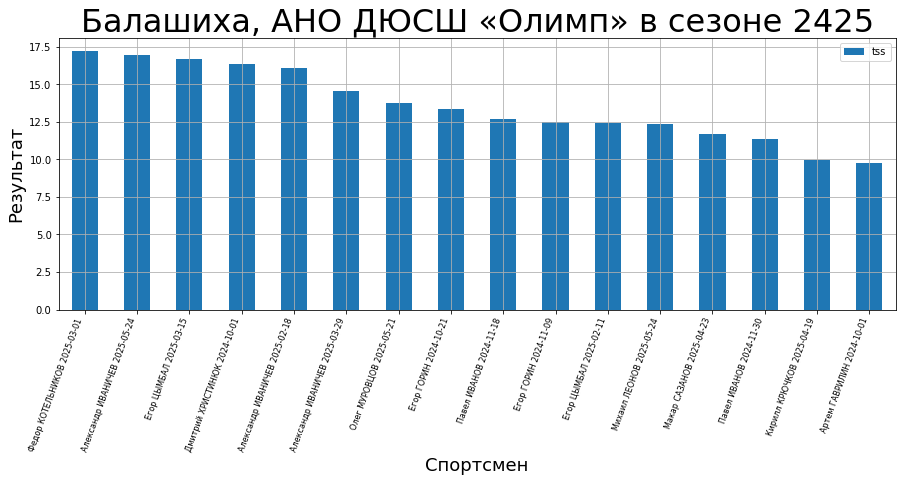

In [11]:
ffkkmo_ra.club_rating_in_season(df, season.value, category.value, club.value, limit=limit_val.value)

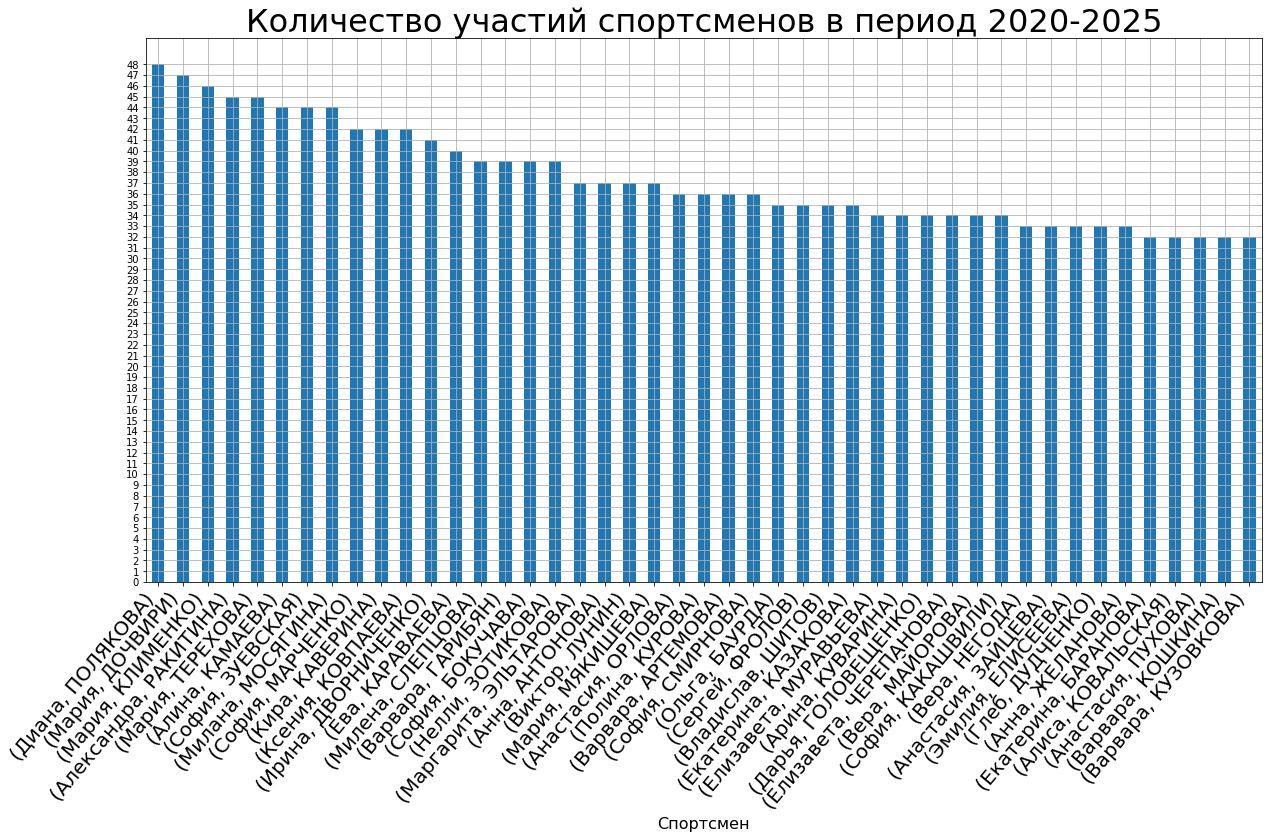

In [12]:
data = df[df['segment']=='Произвольная программа'].groupby(['firstname', 'lastname']).count().sort_values(
    by='date', ascending=False).head(45)['date']
ax = data.plot(
    kind='bar', figsize=(20, 10), grid=True
)
major_ticks = np.arange(0, max(data) + 1, 1)
ax.set_yticks(major_ticks)
plt.title("Количество участий спортсменов в период 2020-2025", fontsize=32)
plt.xlabel('Спортсмен', fontsize=16)
plt.ylabel(f'', fontsize=18)
plt.xticks(fontsize=20, rotation=50, horizontalalignment='right');

In [13]:
df[df['category'].isin(categoies)&(df['season']==2425)].sort_values(by="tss").groupby(["category", "segment"]).last()[['club', 'date', 'firstname', 'lastname', 'tss', 'tes', 'pcs']]

club  \
category                        segment                                                                 
1-й спортивный разряд, девочки  Короткая программа           Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»   
                                Произвольная программа   Ленинский, ООО «Центр спортивных технологий»   
1-й спортивный разряд, мальчики Короткая программа                    Сергиев Посад, ООО «Стремление»   
                                Произвольная программа                Сергиев Посад, ООО «Стремление»   
1-й юношеский разряд, девочки   Произвольная программа        Ступино, МБУ ДО «СШОР им. В.Б. Боброва»   
1-й юношеский разряд, мальчики  Произвольная программа                Сергиев Посад, ООО «Стремление»   
2-й спортивный разряд, девочки  Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
2-й спортивный разряд, мальчики Короткая программа                  Раменское, МБУ ДО «СШ «Раменское»   
                                Произвольная программа                 Лыткарино, МАУ «ЛСК Лыткарино»   
2-й юношеский разряд, девочки   Произвольная программа                  Мытищи, МБУ ДО «СШ «Авангард»   
2-й юношеский разряд, мальчики  Произвольная программа       Долгопрудный, АНО ДО СШФК «Смирнова Тим»   
3-й спортивный разряд, девочки  Произвольная программа                  Подольск, МУ ДО СШОР «Витязь»   
3-й спортивный разряд, мальчики Произвольная программа                            Люберцы, МУДО КСШОР   
3-й юношеский разряд, девочки   Произвольная программа         Красногорск, АНО ДО АФК «Наши Надежды»   
3-й юношеский разряд, мальчики  Произвольная программа       Долгопрудный, АНО ДО СШФК «Смирнова Тим»   
КМС, юноши                      Короткая программа               Одинцово, ООО «АФК «Ангелы Плющенко»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
МС юноши                        Короткая программа               Одинцово, ООО «АФК «Ангелы Плющенко»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
МС, девушки                     Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа           Одинцово, ООО «АФК «Ангелы Плющенко»   
Младшая группа, девочки         Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа   Ленинский, ООО «Центр спортивных технологий»   
Младшая группа, мальчики        Короткая программа                     Одинцово, МБУ ДО СШ «Одинцово»   
                                Произвольная программа              Раменское, МБУ ДО «СШ «Раменское»   
Старшая группа, девочки         Короткая программа       Ленинский, ООО «Центр спортивных технологий»   
                                Произвольная программа   Ленинский, ООО «Центр спортивных технологий»   
Старшая группа, мальчики        Короткая программа                    Сергиев Посад, ООО «Стремление»   
                                Произвольная программа                Сергиев Посад, ООО «Стремление»   
Юный фигурист, девочки          Катание под музыку                     Лыткарино, МАУ «ЛСК Лыткарино»   
                                Произвольная программа  Жуковский, МБУ ДО «СШ – Центр спорта «Метеор»   
Юный фигурист, мальчики         Катание под музыку                     Лыткарино, МАУ «ЛСК Лыткарино»   
                                Произвольная программа              Раменское, МБУ ДО «СШ «Раменское»   

                                                              date  firstname  \
category                        segment                                         
1-й спортивный разряд, девочки  Короткая программа      2024-09-14  Елизавета   
                                Произвольная программа  2025-03-29     Ан

In [14]:
df[(df['season']==2425)].groupby("category").count()['date']

category
1-й спортивный разряд, девочки      880
1-й спортивный разряд, мальчики      72
1-й юношеский разряд, девочки       429
1-й юношеский разряд, мальчики       27
2-й спортивный разряд, девочки     1270
2-й спортивный разряд, мальчики      44
2-й юношеский разряд, девочки       810
2-й юношеский разряд, мальчики       69
3-й спортивный разряд, девочки      701
3-й спортивный разряд, мальчики      56
3-й юношеский разряд, девочки       586
3-й юношеский разряд, мальчики       16
КМС, юноши                           30
МС юноши                             12
МС, девушки                         108
Младшая группа, девочки              59
Младшая группа, мальчики             10
Старшая группа, девочки              60
Старшая группа, мальчики              8
Юный фигурист, девочки              173
Юный фигурист, мальчики              15
Name: date, dtype: int64

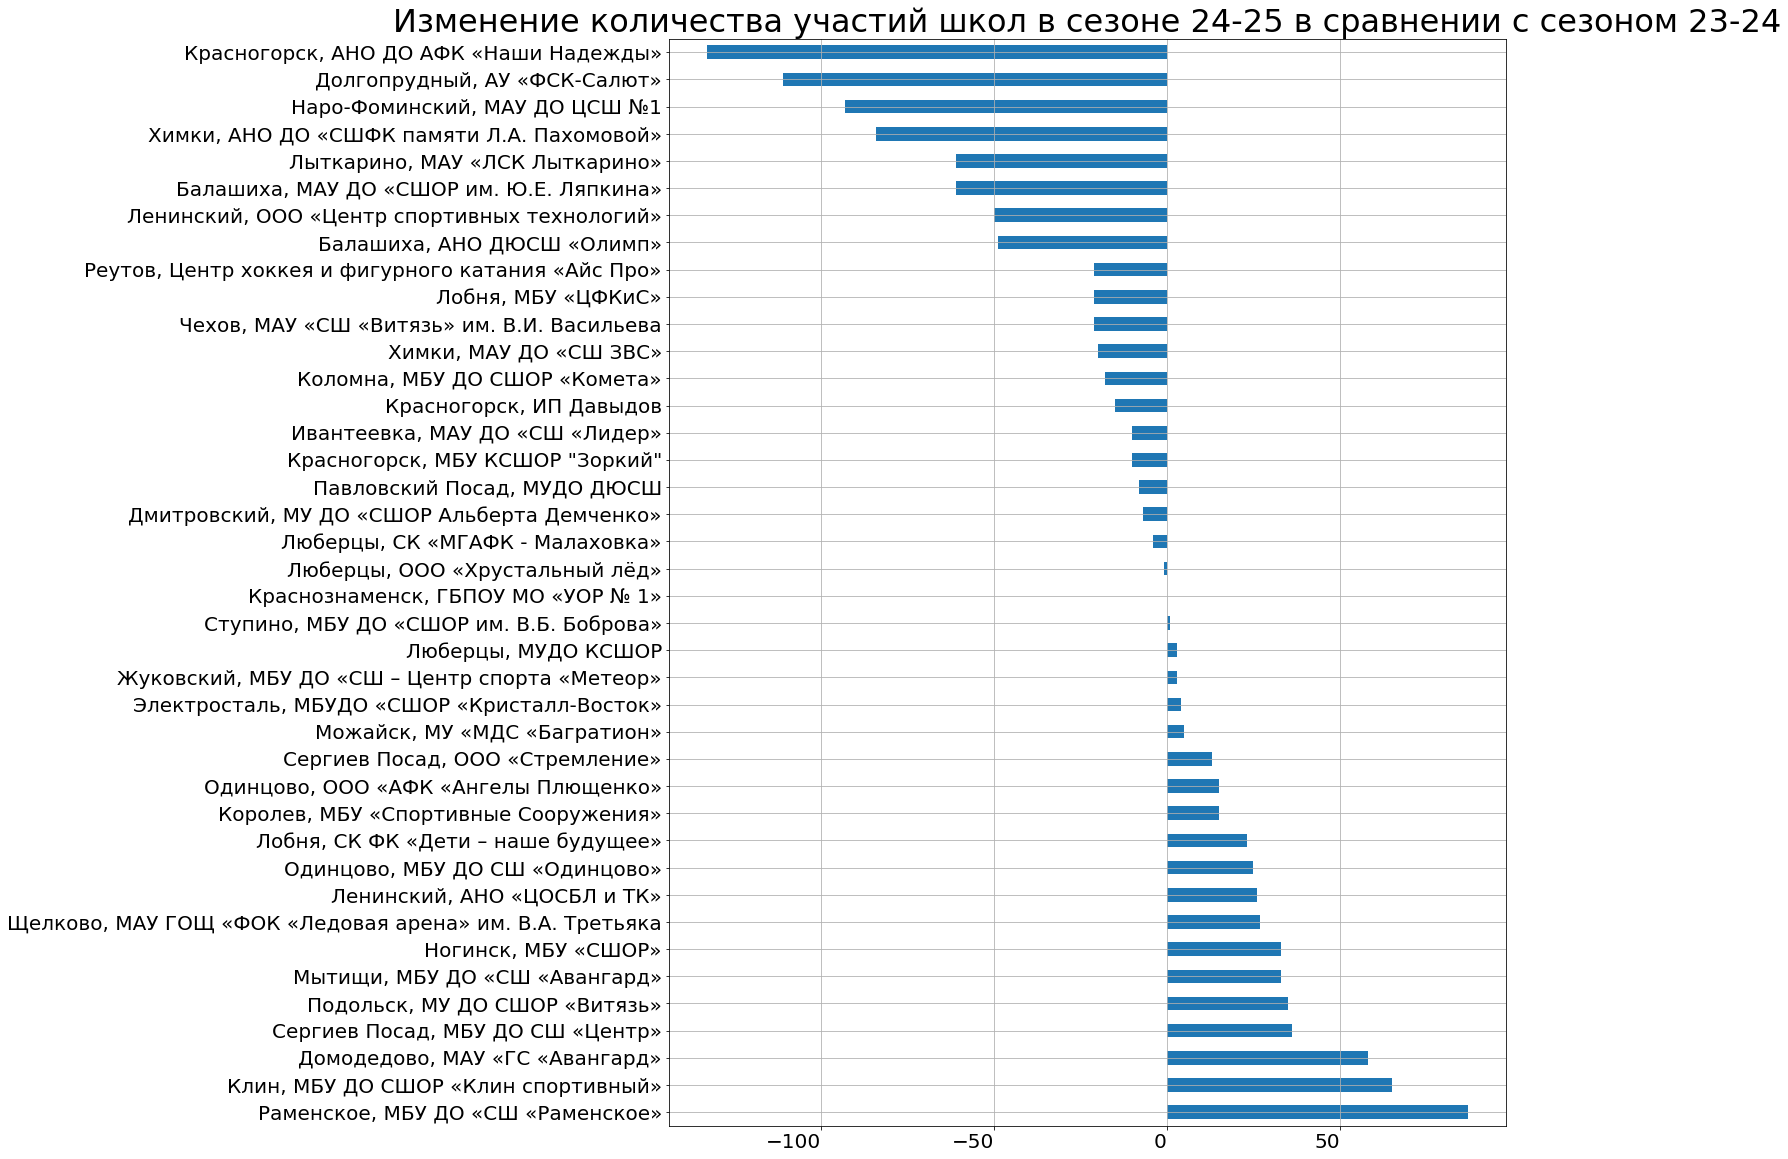

In [16]:
df_groupped = df.groupby(["date", "firstname", "lastname", "club"]).last().reset_index()
pivot_df = pd.pivot_table(df_groupped, values='date', index='club', columns='season', aggfunc='count')
tdf = pivot_df[2425] - pivot_df[2324]
tdf = tdf.dropna()
tdf.sort_values(ascending=False).plot(
    kind='barh', figsize=(15, 20), grid=True
)
plt.title("Изменение количества участий школ в сезоне 24-25 в сравнении с сезоном 23-24", fontsize=32)
plt.ylabel(f'', fontsize=18)
plt.yticks(fontsize=20, rotation=0, horizontalalignment='right');
plt.xticks(fontsize=20, rotation=0, horizontalalignment='right');

In [17]:
pd.set_option('display.max_rows', 100)
display(pivot_df)

season,2021,2122,2223,2324,2425
club,,,,,
"Балашиха, АНО ДЮСШ «Олимп»",30.0,89.0,66.0,105.0,56.0
"Балашиха, МАУ ДО «СШОР им. Ю.Е. Ляпкина»",407.0,482.0,347.0,336.0,275.0
"Балашиха, СКФК «Голден Стар»",17.0,NaN,NaN,NaN,NaN
"Дмитровский, ИП Карпенко",NaN,14.0,27.0,23.0,NaN
"Дмитровский, МУ ДО «СШОР Альберта Демченко»",118.0,177.0,136.0,111.0,104.0
"Долгопрудный, АНО ДО СШФК «Смирнова Тим»",NaN,NaN,NaN,NaN,44.0
"Долгопрудный, АУ «ФСК-Салют»",184.0,233.0,226.0,182.0,71.0
"Долгопрудный, СК «Альфа»",43.0,NaN,NaN,NaN,NaN
"Домодедово, ИП Спицин",87.0,58.0,49.0,4.0,NaN


<Axes: >

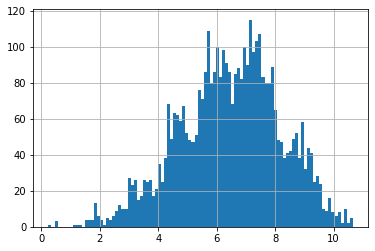

In [19]:
df[(df['category'] == '3-й юношеский разряд, девочки')]['tes'].hist(bins=100)

['3-й юношеский разряд, мальчики',
 '3-й юношеский разряд, девочки',
 '2-й юношеский разряд, мальчики',
 '2-й юношеский разряд, девочки',
 '1-й юношеский разряд, мальчики',
 '1-й юношеский разряд, девочки',
 '3-й спортивный разряд, мальчики',
 '3-й спортивный разряд, девочки',
 '2-й спортивный разряд, мальчики',
 '2-й спортивный разряд, мальчики',
 '2-й спортивный разряд, девочки',
 '2-й спортивный разряд, девочки',
 '1-й спортивный разряд, мальчики',
 '1-й спортивный разряд, мальчики',
 '1-й спортивный разряд, девочки',
 '1-й спортивный разряд, девочки']

In [20]:
tes_min = dict(zip([(x[0], x[1]) for x in ffkkmo_ra.sorter_names], [(x[2]) for x in ffkkmo_ra.sorter_names]))

In [21]:
def calc_procentage(x):
    return len(list(filter(lambda y : y > avg(x[1]), x[0]))) / len(x[0]) * 100

In [22]:
for x in tes_min:
    df.loc[(df['category'] == x[0]) & (df['segment'] == x[1]), 'tes_min'] = tes_min[x]
df['tes_done'] = df['tes'] >= df['tes_min']

In [40]:
df.category.unique()

array(['3-й юношеский разряд, мальчики', '3-й юношеский разряд, девочки',
       '2-й юношеский разряд, мальчики', '2-й юношеский разряд, девочки',
       '1-й юношеский разряд, мальчики', '1-й юношеский разряд, девочки',
       '3-й спортивный разряд, мальчики',
       '3-й спортивный разряд, девочки', '1-й спортивный разряд, девочки',
       '1-й спортивный разряд, мальчики',
       '2-й спортивный разряд, девочки',
       '2-й спортивный разряд, мальчики', 'МС, девушки', 'КМС, юноши',
       'Юный фигурист, девочки', 'Юный фигурист, мальчики',
       'Младшая группа, девочки', 'Младшая группа, мальчики',
       'Старшая группа, девочки', 'Старшая группа, мальчики', 'МС юноши'],
      dtype=object)

In [46]:
cats = list(set([x[0] for x in ffkkmo_ra.sorter_names]))

In [47]:
pvt = pd.pivot_table(
    df.query("category in @cats"), 
    values='tes_done', 
    index=['category', 'segment'], 
    columns='season', 
    aggfunc=lambda x : f"{sum(x) / len(x) * 100:.2f}%"
)
sorterIndex = dict(zip([(x[0], x[1]) for x in ffkkmo_ra.sorter_names], range(len(ffkkmo_ra.sorter_names))))
pvt['category_Rank'] = pvt.index.map(lambda x : sorterIndex[x])
pvt.sort_values('category_Rank', ascending = True, inplace = True)
pvt.drop('category_Rank', 1, inplace = True)
pvt

,season,2021,2122,2223,2324,2425
category,segment,,,,,
"3-й юношеский разряд, мальчики",Произвольная программа,92.86%,90.22%,48.61%,42.37%,56.25%
"3-й юношеский разряд, девочки",Произвольная программа,88.48%,89.13%,60.18%,50.08%,54.78%
"2-й юношеский разряд, мальчики",Произвольная программа,47.73%,59.15%,24.49%,24.56%,18.84%
"2-й юношеский разряд, девочки",Произвольная программа,54.61%,60.14%,31.74%,24.30%,26.05%
"1-й юношеский разряд, мальчики",Произвольная программа,29.17%,45.59%,33.33%,66.67%,44.44%
"1-й юношеский разряд, девочки",Произвольная программа,45.10%,48.91%,54.22%,56.77%,58.28%
"3-й спортивный разряд, мальчики",Произвольная программа,45.12%,30.56%,22.45%,12.50%,26.79%
"3-й спортивный разряд, девочки",Произвольная программа,29.81%,32.80%,32.96%,36.71%,31.38%
"2-й спортивный разряд, мальчики",Короткая программа,49.23%,65.31%,63.49%,74.29%,27.27%


In [ ]:
import seabor

In [35]:
pvt.index

,date,place,online,category,segment,rank,firstname,middlename,lastname,club,tss,tes,pcs,year,month,season,tes_min,tes_done


In [ ]:
pvt['2425'].plot(kind='barh')

In [ ]:
df['tes_pcs_ratio'] = df['tes']/df['pcs']

In [ ]:
df[(df['season'] == '2324')]['tes_pcs_ratio'].hist(bins=50, figsize=(15, 5), range=(0, 2))